# Case study of uniaxial compression tests

This is an example of how to use Paramaterial to process a dataset of uniaxial compression test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [32]:
import paramaterial
import importlib

importlib.reload(paramaterial)
pam = paramaterial
DataSet, DataItem = pam.plug.DataSet, pam.plug.DataItem

## Data preparation


### Raw data
1. Create two directories: "data", "info".
2. Save all csv files into a directory called "data/01 raw data".
3. Generate a corresponding info table using make_info_table function.
4. Fill in the raw info and apply a naming convention.
5. Rename the files

In [33]:
# raw_info = pam.preparing.make_info_table('data/01 raw data', columns=['temperature', 'rate', 'material'])
# raw_info.to_excel('info/00 info unfilled.xlsx')
# raw_info.head()

Add the metadata into the excel spreadsheet.
Apply a naming convention in the "test id" column.

In [34]:
# raw_info = pd.read_excel('info/01 raw info.xlsx')
# raw_info.head()

Copy raw data and info into backup, incase raw data becomes damaged during processing.

In [35]:
# pam.preparing.copy_data_and_info(old_data_dir='data/01 raw data', new_data_dir='data/00 backup data',
#                                  old_info_path='info/01 raw info.xlsx', new_info_path='info/00 backup info.xlsx')

### Prepared data

Rename files according to test id.

In [36]:
# pam.preparing.rename_by_test_id('data/01 raw data', 'info/01 raw info.xlsx')

Check that column headers of data files are all the same. If not the same, fix.

In [37]:
# pam.preparing.check_column_headers('data/01 prepared data')

In [38]:
raw_set = DataSet('data/01 raw data', 'info/01 raw info.xlsx')

### Dataitem EDA
Look at one dataitem. Notice the use of the square brackets to get a subset, then to get a slice, then to get a single item.

In [39]:
raw_item = raw_set[{'rate': [1], 'material': ['H560']}][0:2][0]  # speed up get slice
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][1]
# dataitem = raw_dataset[{'rate': [1], 'material': ['H560']}][0:2][2]

raw_item

DataItem with test id baron_test_065.
Info: {'test id': 'baron_test_065', 'old filename': 'testID_0148.csv', 'test type': 'UC', 'material': 'H560', 'temperature': 360, 'rate': 1, 'L_0': 15, 'D_0': 10}
Data:    Time(sec)  Force(kN)   Jaw(mm)  PowAngle(deg)  Power(W)       Pram  \
0        0.0   0.913843  0.511157            0.0         0  10.594783   
1        0.1   0.907306  0.024974            0.0         0  10.594783   

      PTemp    Strain  Stress(MPa)  Stroke(mm)     TC1(C)  wedge(mm)  
0  0.001362  0.034665    11.233622   10.594357  25.704758  -9.116560  
1  0.219614  0.001707    11.535138   10.595199  25.719183  -9.463981  

In [40]:
raw_item.data = raw_item.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'Stroke(mm)', 'wedge(mm)', 'PTemp'])
# sns.pairplot(pd.concat([dataitem.data.iloc[:-199:200], dataitem.data.iloc[-10:]]), hue='TC1(C)', palette='plasma')

### Dataset EDA

In [41]:
raw_set.info_table.nunique()

test id         167
old filename    167
test type         1
material          3
temperature       6
rate              4
L_0               1
D_0               1
dtype: int64

Make the experimental matrix.

In [42]:
data_matrix = raw_set.info_table[['material', 'temperature', 'rate']].value_counts().sort_index()
data_matrix = data_matrix.to_frame().reset_index()
data_matrix.columns = ['material', 'temperature', 'rate', 'count']
data_matrix.pivot_table(index=['material', 'rate'], columns='temperature', values='count').fillna(0).astype(int)

temperature    300  330  360  400  450  500
material rate                              
AC       1       0    0    0    2    2    2
         10      2    2    2    2    2    2
         50      2    3    3    2    0    0
         100     2    2    3    2    0    0
H560     1       0    0    2    2    3    2
         10      6    4    4    2    2    2
         50      2    2    2    5    0    0
         100     2    2    2    1    0    0
H580     1       0    0    1    5    4    2
         10      9    7    4    7    7    4
         50      4    5    3    4    0    0
         100     2    5    5    5    0    0

Plot the dataset.

Iterating over DataItems in DataSet: 167it [00:10, 16.11it/s]


<AxesSubplot:xlabel='Strain'>

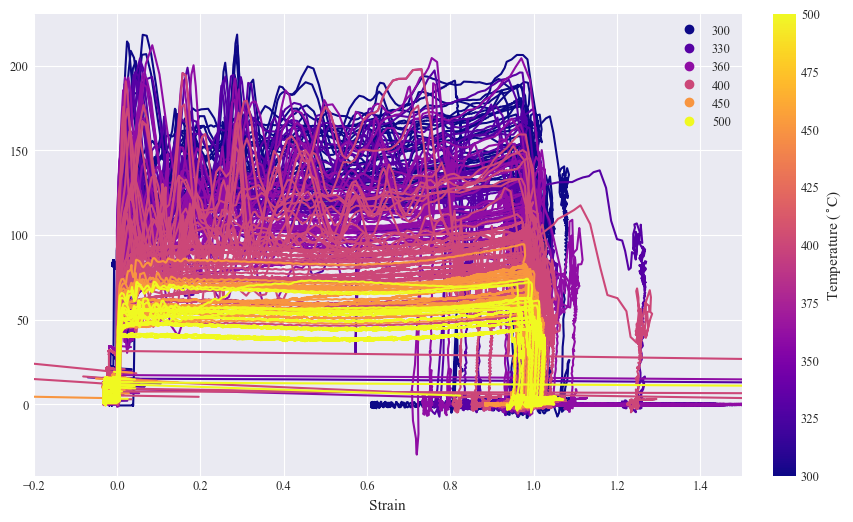

In [43]:
def ds_plot(dataset: DataSet, **kwargs) -> plt.Axes:
    return pam.plotting.dataset_plot(
        dataset, x='Strain', y='Stress(MPa)', color_by='temperature',
        cbar=True, cbar_label='Temperature ($^{\circ}$C)',
        xlim=(-0.2, 1.5), grid=True, **kwargs
    )

ds_plot(raw_set)

Iterating over DataItems in DataSet: 6it [00:00, 12.24it/s]
Iterating over DataItems in DataSet: 12it [00:00, 20.93it/s]
Iterating over DataItems in DataSet: 10it [00:00, 24.26it/s]
Iterating over DataItems in DataSet: 9it [00:00, 13.18it/s]
Iterating over DataItems in DataSet: 9it [00:00, 20.55it/s]
Iterating over DataItems in DataSet: 20it [00:00, 23.37it/s]
Iterating over DataItems in DataSet: 11it [00:00, 24.37it/s]
Iterating over DataItems in DataSet: 7it [00:00, 22.91it/s]
Iterating over DataItems in DataSet: 12it [00:00, 19.90it/s]
Iterating over DataItems in DataSet: 38it [00:01, 20.72it/s]
Iterating over DataItems in DataSet: 16it [00:00, 23.48it/s]
Iterating over DataItems in DataSet: 17it [00:00, 21.47it/s]


(<Figure size 1200x800 with 13 Axes>,
 array([[<AxesSubplot:title={'center':'1 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'10 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'50 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:title={'center':'100 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot:xlabel='Strain', ylabel='Stress (MPa)'>]],
       dtype=object))

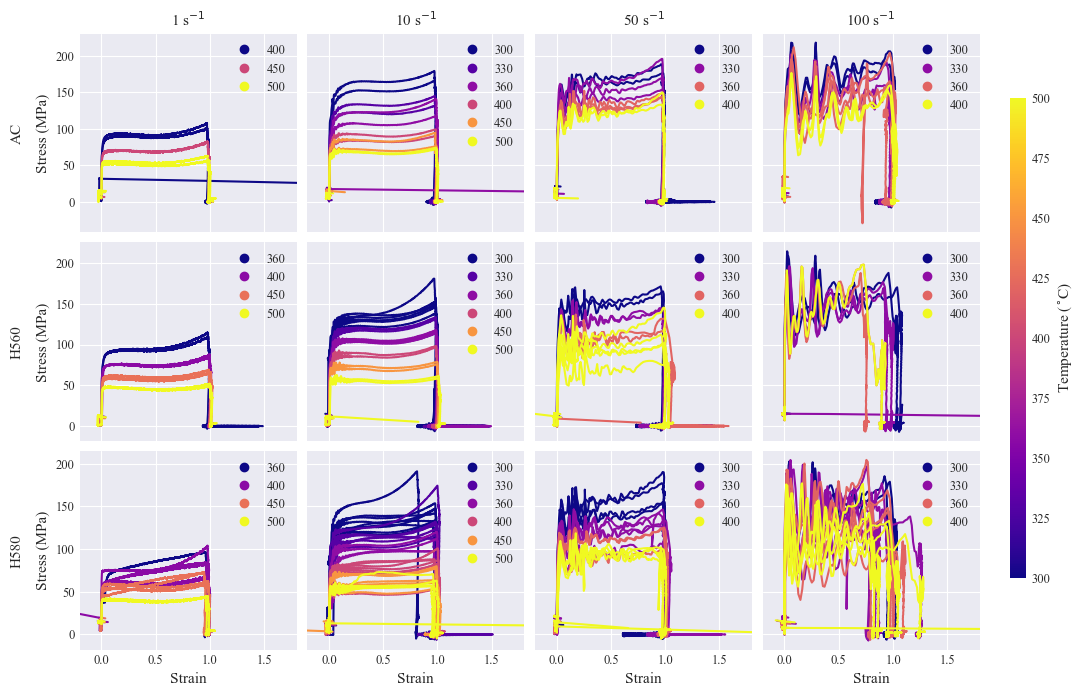

In [44]:
def ds_subplot(dataset: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(
    dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)',
    shape=(3,4), rows_by='material', cols_by='rate',
    row_vals=[['AC'], ['H560'], ['H580']], col_vals=[[1], [10], [50], [100]],
    row_titles=['AC', 'H560', 'H580'], col_titles=['1 s$^{-1}$', '10 s$^{-1}$', '50 s$^{-1}$', '100 s$^{-1}$'],
    color_by='temperature', cbar=True, cbar_label='Temperature ($^{\circ}$C)',
    xlim=(-0.2, 1.8), grid=True, wspace=0.05, hspace=0.05
    )

ds_subplot(raw_set)

## Processing
We now want to:
- Trim the data
- Apply friction corrections
- Make representative curves
- Screen the data

### Trimming the data
- Remove unnecessary columns
- Trim leading and trailing data using time-step change
- Trim remaining trailing data after max force

In [45]:
def drop_columns(di: DataItem) -> DataItem:
    di.data = di.data.drop(columns=['PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Stroke(mm)', 'wedge(mm)'])
    return di


raw_set = raw_set.apply_function(drop_columns)
raw_set

DataSet with 167 DataItems.
Columns in info table: test id, old filename, test type, material, temperature, rate, L_0, D_0
Columns in data: Time(sec), Force(kN), Jaw(mm), Strain, Stress(MPa), TC1(C)

#### Trim using sampling rate change
After calculating the time-steps, we remove data that was sampled with a larger time-step.

<AxesSubplot:>

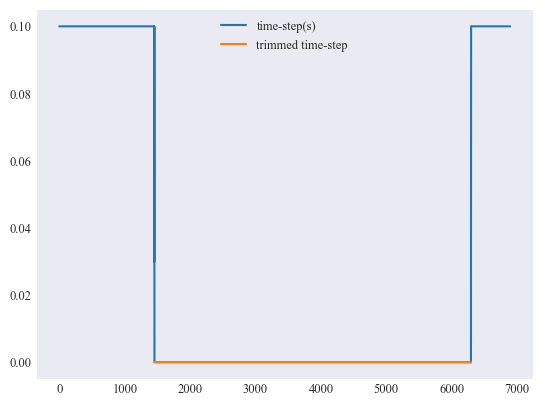

In [46]:
# calculate time-step
raw_item = raw_set[0]
time_step = np.diff(raw_item.data['Time(sec)'])
raw_item.data['time-step(s)'] = np.hstack([time_step[0], time_step])
ax = raw_item.data.plot(y='time-step(s)')
# trim by time-step
raw_item.data = raw_item.data[raw_item.data['time-step(s)'] < 0.02]
raw_item.data.plot(ax=ax, y='time-step(s)', label='trimmed time-step')

Trim dataset using time-step change. Notice how the origin data has been cleaned.

Iterating over DataItems in DataSet: 167it [00:11, 14.66it/s]


<AxesSubplot:xlabel='Strain'>

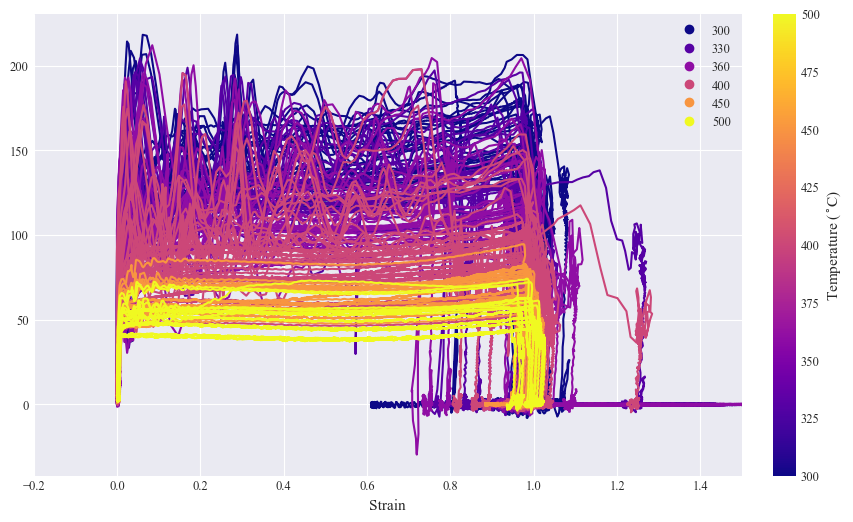

In [47]:
def trim_using_time_step_change(di: DataItem) -> DataItem:
    t_diff = np.diff(di.data['Time(sec)'])
    di.data['time diff'] = np.hstack([t_diff[0], t_diff])
    di.data = di.data[di.data['time diff'] < 0.02]
    return di


trim_set = raw_set.apply_function(trim_using_time_step_change)
ds_plot(trim_set)
# ds_subplot(trimmed_dataset)

#### Trim using max force
The end of a compression test can be identified my the maximum force.

<AxesSubplot:xlabel='Strain'>

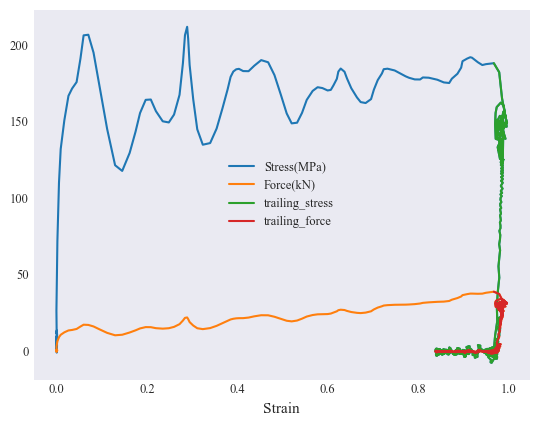

In [48]:
# investigate using max force index for trimming stress
raw_item = trim_set[0]

max_force_index = raw_item.data['Force(kN)'].idxmax()
trailing_data = raw_item.data.iloc[max_force_index:].copy()
trailing_data[['trailing_stress', 'trailing_force']] = trailing_data[['Stress(MPa)', 'Force(kN)']]
trailing_data['trailing_force'] = trailing_data['Force(kN)']

ax = raw_item.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])
trailing_data.plot(ax=ax, x='Strain', y=['trailing_stress', 'trailing_force'])

<AxesSubplot:xlabel='Strain'>

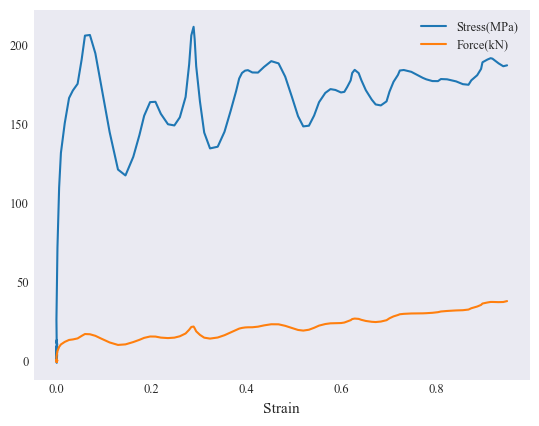

In [49]:
# demonstrate max force trimming for one dataitem
def remove_trailing_data(di: DataItem):
    di.data = di.data.iloc[:di.data['Force(kN)'].idxmax()]
    return di


trimmed_dataitem = remove_trailing_data(raw_item)
trimmed_dataitem.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])

Trim dataset using max force. Notice how the trailing data is trimmed.

Iterating over DataItems in DataSet: 167it [00:11, 15.01it/s]


<AxesSubplot:xlabel='Strain'>

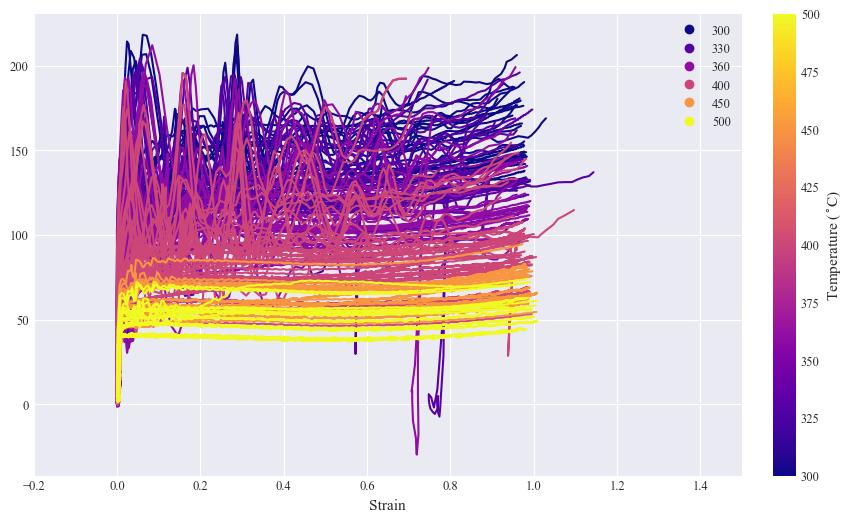

In [50]:
trim_set = trim_set.apply_function(remove_trailing_data)
ds_plot(trim_set)

### Applying the friction correction.
$$
\sigma = P \left[\frac{h}{\mu d} \right]^{-2}\left[\exp\left(\frac{\mu d}{h}\right) - \frac{\mu d}{h} - 1 \right]^{-1}
$$

Demonstrate friction correction for one dataitem

<AxesSubplot:xlabel='Strain'>

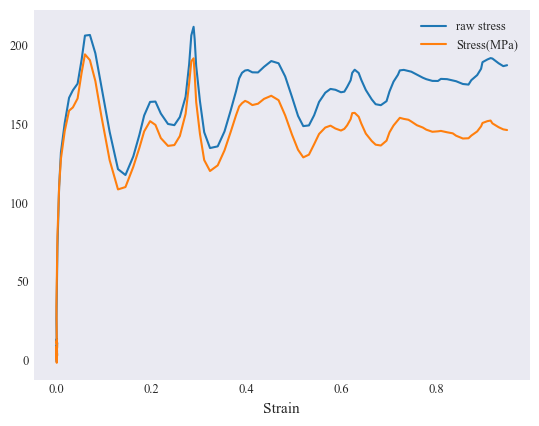

In [51]:
raw_item = trim_set[0]

# apply friction correction function to dataset
def friction_correction(di: DataItem) -> DataItem:
    mu = 0.3  # friction coefficient
    h_0 = di.info['L_0']  # initial height in axial direction
    d_0 = di.info['D_0']  # initial diameter
    h = h_0 - di.data['Jaw(mm)']  # instantaneous height
    d = d_0*np.sqrt(h_0/h)  # instantaneous diameter
    P = di.data['Force(kN)']*1000*4/(np.pi*d ** 2)  # pressure (MPa)
    di.data['Pressure(MPa)'] = P
    di.data['raw stress'] = di.data['Stress(MPa)']
    di.data['Stress(MPa)'] = P/(1 + (mu*d)/(3*h))  # correct stress
    return di

corr_item = friction_correction(raw_item)
corr_item.data.plot(x='Strain', y=['raw stress', 'Stress(MPa)'])

Apply friction correction to dataset.

Iterating over DataItems in DataSet: 167it [00:11, 14.10it/s]


<AxesSubplot:xlabel='Strain'>

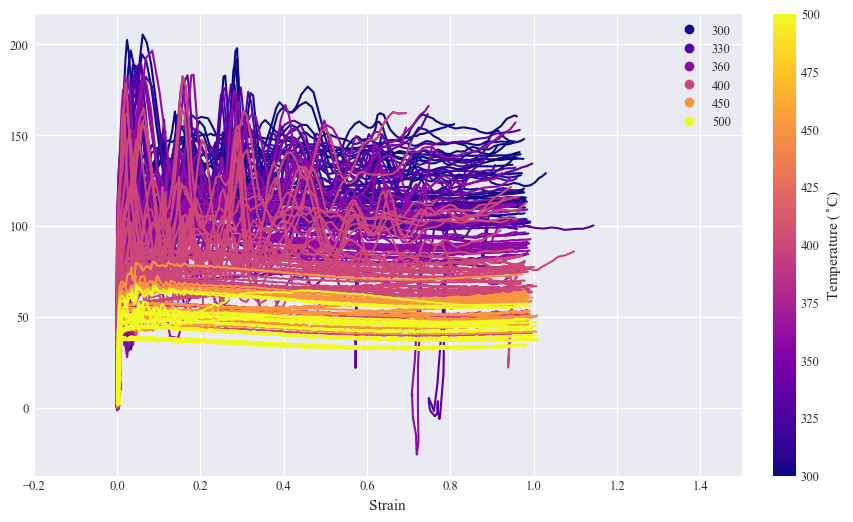

In [52]:
corr_set = trim_set.apply_function(friction_correction)
ds_plot(corr_set)

Iterating over DataItems in DataSet: 6it [00:00, 32.54it/s]
Iterating over DataItems in DataSet: 6it [00:00, 29.80it/s]


<AxesSubplot:xlabel='Strain'>

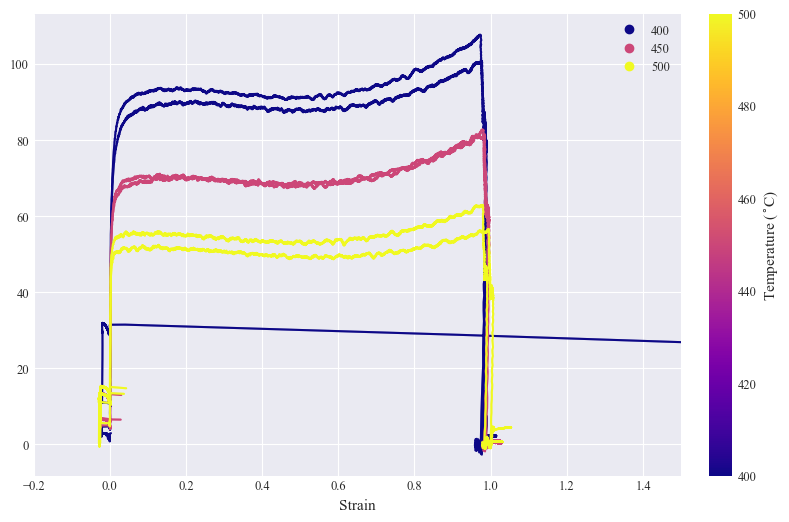

In [53]:
# compare corrected to un-corrected for a subset
ax = ds_plot(trim_set[{'material': ['AC'], 'rate': [1]}], alpha=0.3)
fig = ax.get_figure()
fig.delaxes(fig.axes[1])
ds_plot(corr_set[{'material': ['AC'], 'rate': [1]}], ax=ax)

### Write processed data to new folder

In [54]:
corr_set.write_output('data/02 processed data', 'info/02 processed info.xlsx')

Iterating over DataItems in DataSet: 167it [00:05, 28.66it/s]


### Make representative curves

In [55]:
pam.processing.make_representative_curves(corr_set, 'data/03 repr data', 'info/03 repr info.xlsx',
                                          repr_col='Stress(MPa)', repr_by_cols=['temperature', 'material', 'rate'],
                                          interp_by='Strain')

Iterating over DataItems in DataSet: 2it [00:00, 61.67it/s]
Iterating over DataItems in DataSet: 2it [00:00, 66.30it/s]
Iterating over DataItems in DataSet: 2it [00:00, 83.56it/s]
Iterating over DataItems in DataSet: 2it [00:00, 69.15it/s]
Iterating over DataItems in DataSet: 2it [00:00, 74.27it/s]
Iterating over DataItems in DataSet: 2it [00:00, 71.62it/s]
Iterating over DataItems in DataSet: 2it [00:00, 77.13it/s]
Iterating over DataItems in DataSet: 2it [00:00, 52.77it/s]
Iterating over DataItems in DataSet: 6it [00:00, 84.73it/s]
Iterating over DataItems in DataSet: 6it [00:00, 66.76it/s]
Iterating over DataItems in DataSet: 2it [00:00, 91.14it/s]
Iterating over DataItems in DataSet: 2it [00:00, 69.15it/s]
Iterating over DataItems in DataSet: 2it [00:00, 66.84it/s]
Iterating over DataItems in DataSet: 2it [00:00, 58.11it/s]
Iterating over DataItems in DataSet: 9it [00:00, 87.61it/s]
Iterating over DataItems in DataSet: 9it [00:00, 73.07it/s]
Iterating over DataItems in DataSet: 4it

Iterating over DataItems in DataSet: 0it [00:00, ?it/s]


KeyError: 'Strain'

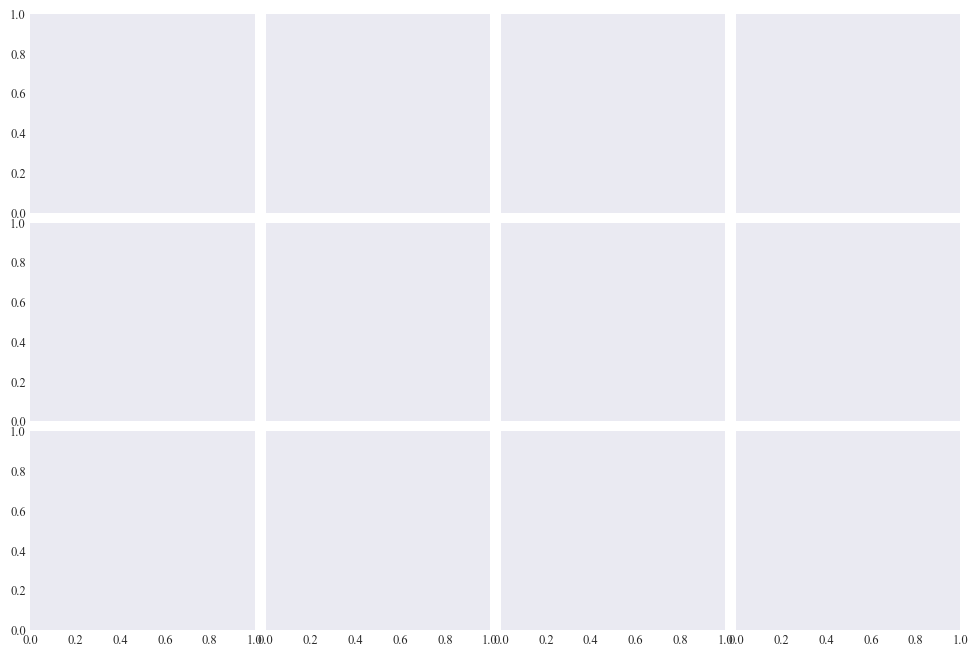

In [56]:
repr_set = DataSet('data/03 repr data', 'info/03 repr info.xlsx', test_id_key='repr id')

ds_subplot(repr_set)

## Screening
1. Setup a screening pdf
2. Add the repr curve
3. Add the data
4. Add the checkboxes
5. Make the pdf
6. Mark the pdf
7. Discard marked items

In [ ]:
proc_set = DataSet('data/02 processed data', 'info/02 processed info.xlsx')
repr_set = DataSet('data/03 repr data', 'info/03 repr info.xlsx', test_id_key='repr id')

# setup screening plot
color_by = 'temperature'
color_norm = plt.Normalize(vmin=proc_set.info_table[color_by].min(), vmax=proc_set.info_table[color_by].max())

def screening_plot(di: DataItem) -> None:
    """Screening plot function."""

    # get other similar data items
    subset_filter = {'material': di.info['material'], 'temperature': di.info['temperature'],
                     'rate': di.info['rate']}
    similar_set = proc_set[subset_filter]

    # get associated representative data
    repr_item_set = repr_set[subset_filter]
    assert len(repr_item_set) == 1  # should be only one repr item

    # plot dataitem
    ax = di.data.plot(x='Strain', y='Stress(MPa)', color='k', legend=False)

    # plot representative curve
    ax = pam.plotting.dataset_plot(
        repr_item_set, x='interp_Strain', y='mean_Stress(MPa)', ylabel='Stress (MPa)', ax=ax,
        color_by='temperature', color_by_label=r'Temp (${^\circ}$C):', color_norm=color_norm,
        style_by='material', style_by_label='Material:', width_by='rate', width_by_label='Rate (s$^{-1}$):',
        xlim=(-0.2, 1.5), grid=True, fill_between=('min_Stress(MPa)', 'max_Stress(MPa)'), alpha=0.2,
        figsize=(10, 5.8),
    )

    # plot similar curves
    ax = pam.plotting.dataset_plot(
        similar_set, x='Strain', y='Stress(MPa)', ax=ax, color_by='temperature', color_by_label=r'Temp (${^\circ}$C):',
        color_norm=color_norm, style_by='material', style_by_label='Material:', width_by='rate',
        width_by_label='Rate (s$^{-1}$):', xlim=(-0.2, 1.5), grid=True,
        alpha=0.5, figsize=(10, 5.8),
    )

    # add title with number of similar curves
    ax.set_title(f'{len(similar_set)} similar curves')
    ax.set_title(f'{di.info["material"]} at {di.info["temperature"]} C and {di.info["rate"]} s$^{{-1}}$. '
                 f'One of {len(similar_set)}.')

# todo: run screening
pam.processing.make_screening_pdf(proc_set, screening_plot, 'data/04 screening.pdf')

## Modelling
1. Identify points of interest algorithmically
2. Fit material model